## UZOP PROJEKT - TREĆI DIO
# Replikacija rezultata i poboljšanje

Autor: 
- Lucija Lovrić, 0036540890
- Karla Šoštar, 
- Karlo Lučan, 

**Opis skupa podataka**

Skup podataka "Open University Learning Analytics Dataset" (OULAD) anonimizirani je skup podataka koji sadrži informacije o studentima i njihovim interakcijama u online okruženju za učenje na Open University u Ujedinjenom Kraljevstvu (UK). Ovaj skup podataka obuhvaća 32 593 studenata upisana na 7 online kolegija.

Podaci uključuju demograske (spol, dobna skupina, razina obrazovanja, invaliditet), kao i bihevioralne varijable (broj klikova u VLE-u, datum registracije, prethodni pokušaji polaganja kolegija, rezultat prvog zadatka). Ciljnu varijablu predstavlja konačni ishod studenta koja može biti klasificirana u 4 kategorije: Withdrawn (povlačenje sa studija), Fail (pad), Pass (prolaz) i Distinction (dobivanje posebnog priznanja).

# Učitavanje podataka

In [24]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


In [25]:
df = pd.read_csv("data_projekt_3.csv")

Podatke smo očistili od monotonih, konstantnih, nedostajućih i stršećih vrijednosti u sklopu drugog dijela projekta te smo ih od tamo izveli i uveli u ovu Jupyter bilježnicu. U nastavku smo priložili osnovne informacije o dataframe-u, kao i kratki uvid u njegovih prvih nekoliko redaka.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32586 entries, 0 to 32585
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32586 non-null  object 
 1   code_presentation           32586 non-null  object 
 2   id_student                  32586 non-null  int64  
 3   gender                      32586 non-null  object 
 4   region                      32586 non-null  object 
 5   highest_education           32586 non-null  object 
 6   imd_band                    32586 non-null  object 
 7   age_band                    32586 non-null  object 
 8   num_of_prev_attempts        32586 non-null  int64  
 9   studied_credits             32586 non-null  int64  
 10  disability                  32586 non-null  object 
 11  final_result                32586 non-null  object 
 12  date_registration           32586 non-null  float64
 13  sum_click                   325

In [27]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,sum_click,module_presentation_length,score
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,934.0,268,78.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,1435.0,268,70.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,281.0,268,0.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,2158.0,268,72.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,1034.0,268,69.0


# Replikacija rezultata

### Korelacije među značajkama

In [28]:
df_corr = df.copy()

df_corr["highest_education_num"] = df_corr["highest_education"].map({
    "No Formal quals": 0,
    "Lower Than A Level": 1,
    "A Level or Equivalent": 2,
    "HE Qualification": 3,
    "Post Graduate Qualification": 4
})

df_corr["age_band_num"] = df_corr["age_band"].map({
    "0-35": 0,
    "35-55": 1,
    "55<=": 2
})

df_corr["imd_band_num"] = df_corr["imd_band"].map({
    "0-10%": 0,
    "10-20": 1,
    "20-30%": 2,
    "30-40%": 3,
    "40-50%": 4,
    "50-60%": 5,
    "60-70%": 6,
    "70-80%": 7,
    "80-90%": 8,
    "90-100%": 9,
    "Unknown": 10
})

df_corr["gender_num"] = df_corr["gender"].map({"F": 0, "M": 1})
df_corr["disability_num"] = df_corr["disability"].map({"N": 0, "Y": 1})

df_corr["final_result_num"] = df_corr["final_result"].map({
    "Withdrawn": 0,
    "Fail": 1,
    "Pass": 2,
    "Distinction": 3
})

In [29]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32586 entries, 0 to 32585
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32586 non-null  object 
 1   code_presentation           32586 non-null  object 
 2   id_student                  32586 non-null  int64  
 3   gender                      32586 non-null  object 
 4   region                      32586 non-null  object 
 5   highest_education           32586 non-null  object 
 6   imd_band                    32586 non-null  object 
 7   age_band                    32586 non-null  object 
 8   num_of_prev_attempts        32586 non-null  int64  
 9   studied_credits             32586 non-null  int64  
 10  disability                  32586 non-null  object 
 11  final_result                32586 non-null  object 
 12  date_registration           32586 non-null  float64
 13  sum_click                   325

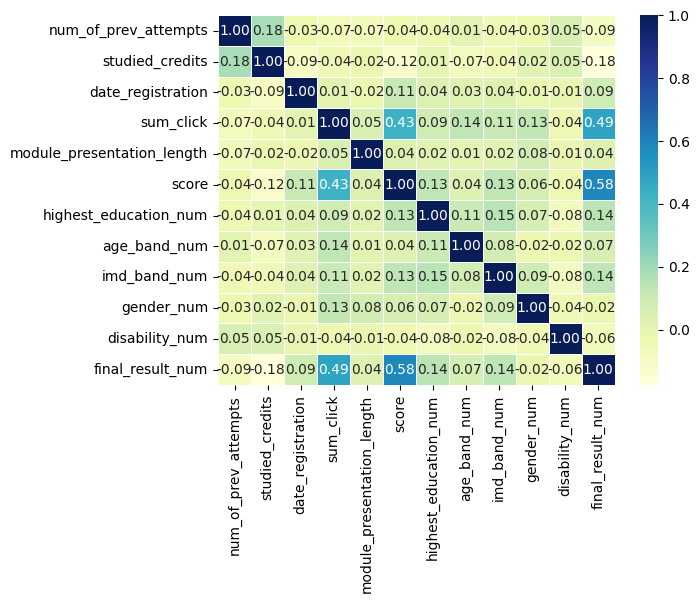

In [30]:
corr_cols = [
    "num_of_prev_attempts",
    "studied_credits",
    "date_registration",
    "sum_click",
    "module_presentation_length",
    "score",
    "highest_education_num",
    "age_band_num",
    "imd_band_num",
    "gender_num",
    "disability_num",
    "final_result_num"
]

df_corr_final = df_corr[corr_cols]
sns.heatmap(df_corr_final.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.show()

Analiza korelacija pokazuje da su score (bodovi prvog zadatka, rani akademski uspjeh studenta) i sum_click (aktivnost i angažiranost studenta) najjače povezani s konačnim ishodom kolegija (final_result). Demografske i socioekonomske varijable pokazuju slabije veze, dok spol i invaliditet nemaju značajnu linearnu povezanost s uspjehom. Rezultati upućuju na to da su ponašajni pokazatelji, poput proaktivnosti i angažmana, informativniji uspjeha od demografskih obilježja.

In [31]:
num_features = [
    "score",
    "sum_click",
    "date_registration",
    "num_of_prev_attempts"
]

cat_features = [
    "highest_education",
    "age_band",
    "gender",
    "disability"
]

X = df[num_features + cat_features].copy()
y = df["final_result"].copy()


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


Kao što je navedeno u članku, podatke smo podijelili u omjeru 70/30. 70% podataka smo koristili kao skup za treniranje, a preostalih 30% kao skup za ispitivanje.

## Decision Tree (One-vs-Rest)

In [34]:
dt_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", OneVsRestClassifier(
        DecisionTreeClassifier(random_state=42)
    ))
])

dt_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Random Forest (One-vs-Rest)

In [35]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", OneVsRestClassifier(
        RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        )
    ))
])

rf_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("=== Decision Tree ===")
print(classification_report(y_test, y_pred_dt))

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))


=== Decision Tree ===
              precision    recall  f1-score   support

 Distinction       0.28      0.13      0.18       907
        Fail       0.30      0.16      0.21      2116
        Pass       0.57      0.51      0.54      3707
   Withdrawn       0.45      0.72      0.55      3046

    accuracy                           0.46      9776
   macro avg       0.40      0.38      0.37      9776
weighted avg       0.45      0.46      0.44      9776


=== Random Forest ===
              precision    recall  f1-score   support

 Distinction       0.37      0.18      0.24       907
        Fail       0.39      0.29      0.33      2116
        Pass       0.59      0.79      0.68      3707
   Withdrawn       0.67      0.62      0.64      3046

    accuracy                           0.57      9776
   macro avg       0.50      0.47      0.47      9776
weighted avg       0.55      0.57      0.55      9776



Nad podacima su provedena dva modela, Decision Tree i Random Forest, čiji su rezultati prikazani iznad.  

**Decision Tree model**  

Decision Tree model postiže ukupnu točnost od 46% uz relativno nizak macro F1-score (37%) što upućuje na slabe performanse na razini svih klasa. Model lakše prepoznaje klase "Pass" i "Withdrawn", dok su manjinske klase, "Distinction" i "Fail", često krivo klasificirane.  
Kod klase "Distinction", recall je izrazito nizak što ukazuje da model prepoznaje samo mali dio studenata koji su stvarno ostvarili iznadprosječne rezultate. Nešto bolje, ali jednako nezadovoljavajuće, ponaša se i za klasu "Fail" što ukazuje da neki studenti koji su pali kolegij nisu identificirani. Ovakva opažanja su očekivana za Decision Tree model koji je osjetljiv na neravnotežu podataka i lako se prenauči. Za klasu "Withdrawn" izračunat je relativno visok recall, ali i niža preciznost. Iz ovog možemo zaključiti da ovaj model ima tendenciju zaključivanja u korist klase "Withdrawn".

**Random Forest model**  

Random Forest model pokazuje vidno bolje rezultate/performanse u odnosu na Decision Tree model s ukupnom točnošću od 57% i znatno višim macro i weighted F1-score vrijednostima.  
Kod klase "Pass" uočen je velik skok u vrijednosti recalla što znači da uspješno identificira većinu studenata koji su položili kolegij. Kod klase "Withdrawn" uočavamo da su vrijednosti precision i recall otprilike jednake što označava pouzdaniju klasifikaciju. Metrike za klase "Fail" i "Distinction" su i dalje slabije u odnosu na "Pass i "WIthdrawn", ali opet jače nego kod Decision Tree modela.

Klase: ['Distinction', 'Fail', 'Pass', 'Withdrawn']

Matrica zabune: Distinction vs Rest
[[8694  175]
 [ 783  124]]


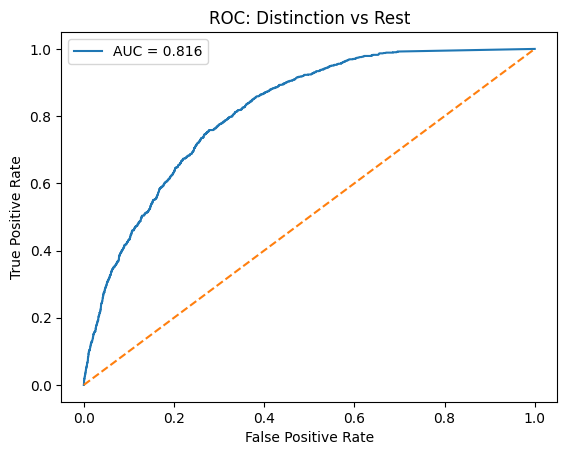


Matrica zabune: Fail vs Rest
[[7094  566]
 [1714  402]]


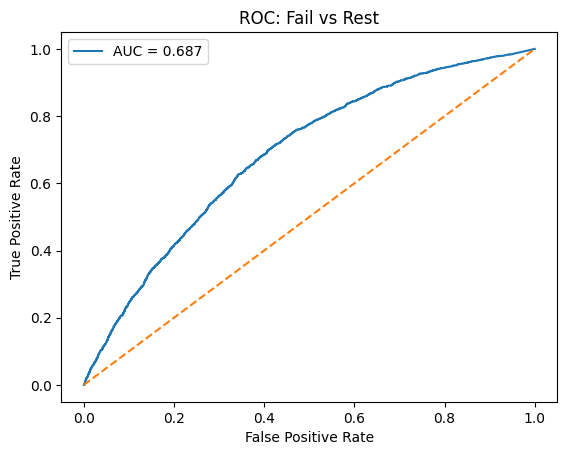


Matrica zabune: Pass vs Rest
[[4592 1477]
 [1296 2411]]


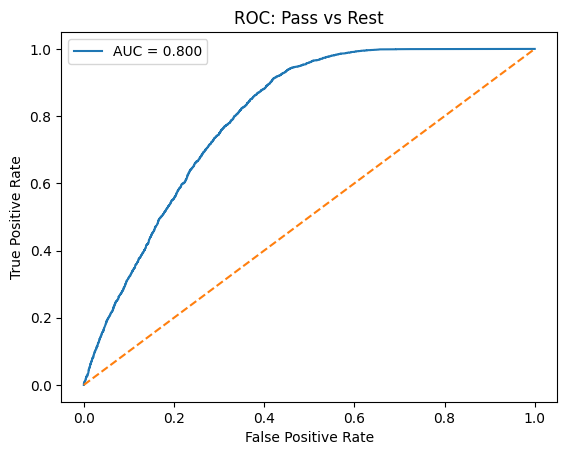


Matrica zabune: Withdrawn vs Rest
[[6090  640]
 [1304 1742]]


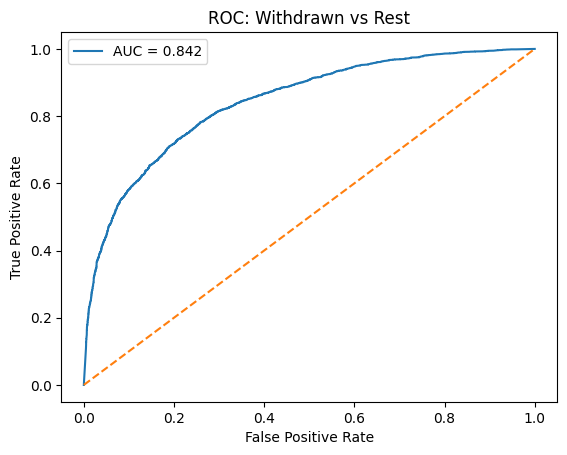

In [37]:
def evaluate_ovr(model, X_test, y_test, class_name):
    # binarna istina: klasa vs rest
    y_true_bin = (y_test == class_name).astype(int)

    # predikcija vjerojatnosti te klase
    proba = model.predict_proba(X_test)
    classes = model.named_steps["clf"].classes_
    idx = list(classes).index(class_name)
    y_score = proba[:, idx]

    # prag 0.5 za binarnu odluku
    y_pred_bin = (y_score >= 0.5).astype(int)

    # matrica zabune
    cm = confusion_matrix(y_true_bin, y_pred_bin)
    print(f"\nMatrica zabune: {class_name} vs Rest")
    print(cm)

    # ROC + AUC
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC: {class_name} vs Rest")
    plt.legend()
    plt.show()

    return roc_auc, cm

classes_to_check = sorted(y.unique())
print("Klase:", classes_to_check)

for c in classes_to_check:
    evaluate_ovr(rf_model, X_test, y_test, c)


Kako bi se detaljnije analizirala sposobnost modela da donosi dobre odluke pri klasifikaciji, provedena je One-vs-Rest evaluacija. U sklopu svake evaluacije ispisana je matrica zabune, a prikazane su i AUC i ROC krivulje.  

**Distinction vs Rest**

Za klasu Distinction dobivena je AUC vrijednost 0.816 što ukazuje na to da model vrlo dobro radi distinkciju između iznadprosječnih studenata i ostalih. ROC krivulja prikazuje konzistentnost modela pri postizanju visoke stope TP klasifikacije i niske FP. Gledajući matricu zabune uočavamo relativno velik broj FN predikcija. Ovo objašnjava niske vrijednosti recalla.

**Fail vs Rest**  

Za klasu "Fail" dobivena je najniža AUC vrijednost (0.687) što ukazuje na to da se ova klasa najteže odvaja od ostatka. Čak i ROC krivulja pokazuje slabije odvajanje pozitivnih i negativnih uzoraka. Matrica zabune također potvrđuje ovaj zaključak budući da model krivo klasificira velik broj primjera (FN - 566 i FP - 1714).

**Pass vs Rest**  

Za klasu "Pass" postignuta je zadovoljavajuća AUC vrijednost  od 0.8. ROC krivulja prikazuje porast TP s porastom FP vrijednosti. Preko matrice zabune zaključujemo da model dobro klasificira ispitanike koji su položili kolegij, ali ima jako velik broj i FP i FN.  

**Withdrawn vs Rest**  

Za ovu klasu postignuta je najbolja AUC vrijednost od 0.842 što znači da model jako dobro razlikuje ispitanike koji su se povukli s kolegija od ostatka ispitanika. Iz ROC krivulje iščitavamo da pri niskim vrijednostima FP rate raste vrijednost TP rate. Rezultat matrice zabune prikazuje dobar omjer (ravnotežu) između TP i FP vrijednosti.



------------------------------------------------------------------------------------------------------------------------------------------------

---------

In [38]:
df_model = df.copy()

df_model["target"] = df_model["final_result"].isin(
    ["Pass", "Distinction"]
).astype(int)

X = df_corr[corr_cols]
y = df_model["target"]

Vrijednosti varijable final_result "Pass" i "Distinction" su mapirane na vrijednost 1, a preostale dvije, "Withdrawn" i "Fail" na 0.

ROC AUC: 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      5162
           1      1.000     1.000     1.000      4614

    accuracy                          1.000      9776
   macro avg      1.000     1.000     1.000      9776
weighted avg      1.000     1.000     1.000      9776



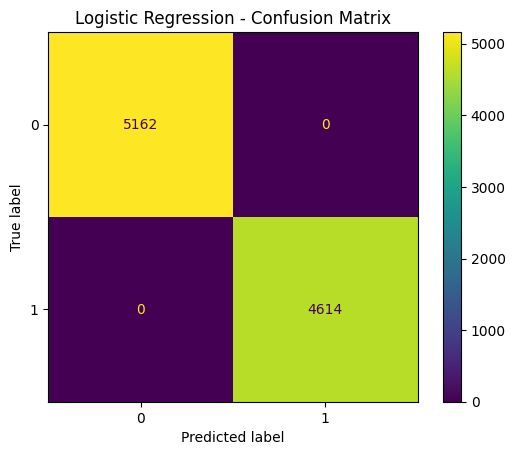

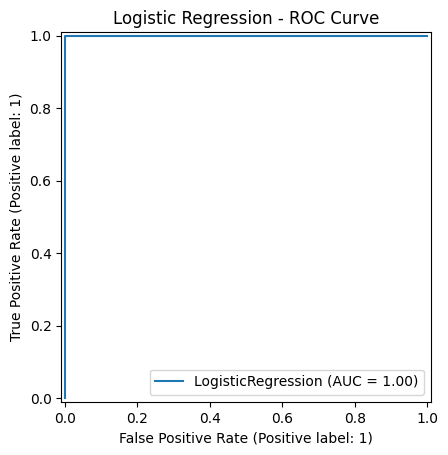

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

# Metrike
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred, digits=3))

# Matrica zabune
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# 6) ROC krivulja
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Logistic Regression - ROC Curve")
plt.show()

Logistička regresija nad samo numeričkim podacima ostvarena je savršena klasifikacija (AUC = 1.0). Ipak, smatramo da je ovakav rezultat posljedica sudjelovanja varijable score u modelu koja je direktno povezana s final_result (ako je ispitanik ostvario velik broj bodova onda je položio kolegij i suprotno). U nastavku ćemo ponoviti model logističke regresije izuzevši varijablu score.

ROC AUC: 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      5162
           1      1.000     1.000     1.000      4614

    accuracy                          1.000      9776
   macro avg      1.000     1.000     1.000      9776
weighted avg      1.000     1.000     1.000      9776



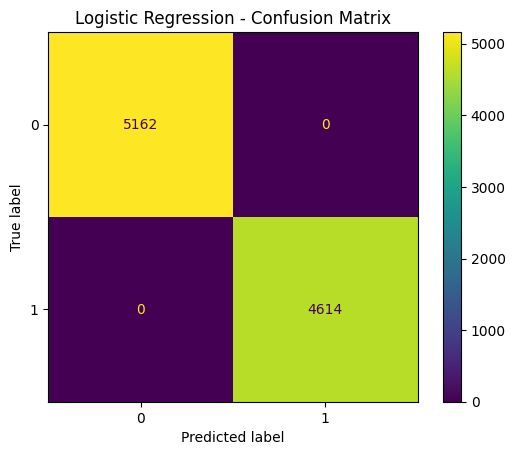

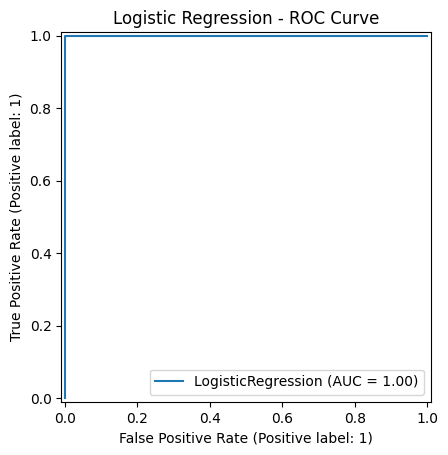

In [40]:
corr_cols_no_score = [
    c for c in corr_cols if c != "score"
]

X2 = df_corr[corr_cols_no_score]
y2 = df_model["target"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2,
    test_size=0.30,
    random_state=42,
    stratify=y2
)

logreg2 = LogisticRegression(max_iter=2000)
logreg2.fit(X2_train, y2_train)

y2_pred = logreg2.predict(X2_test)
y2_prob = logreg2.predict_proba(X2_test)[:, 1]

# Metrike
print("ROC AUC:", roc_auc_score(y2_test, y2_prob))
print(classification_report(y2_test, y2_pred, digits=3))

# Matrica zabune
ConfusionMatrixDisplay.from_estimator(logreg2, X2_test, y2_test)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# 6) ROC krivulja
RocCurveDisplay.from_estimator(logreg2, X2_test, y2_test)
plt.title("Logistic Regression - ROC Curve")
plt.show()
